<a href="https://colab.research.google.com/github/DrAlexSanz/style-transfer/blob/master/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd "/content"
!rm -rf style-transfer

!git clone https://github.com/DrAlexSanz/style-transfer.git
  
%cd "/content/style-transfer"



/content
Cloning into 'style-transfer'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 52 (delta 4), reused 39 (delta 0), pack-reused 0
Unpacking objects: 100% (52/52), done.
/content/style-transfer


In [0]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from nst_utils import *

# %matplotlib inline

In [3]:
%mkdir "/content/style-transfer/pretrained-model"
%cd "/content/style-transfer/pretrained-model"
!wget http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
%cd "/content/style-transfer"

/content/style-transfer/pretrained-model
--2019-09-17 16:41:54--  http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M)
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M  22.7MB/s    in 23s     

2019-09-17 16:42:18 (21.7 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]

/content/style-transfer


In [4]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)


{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' sha


The model is stored in a python dictionary where each variable name is the key and the corresponding value is a tensor containing that variable's value. To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the tf.assign function. In particular, you will use the assign function like this:

model["input"].assign(image)

And then I can access the activation of a given layer:

sess.run(model["conv4_2"])

This is weird enough, but it's the first time I see it.



Al fiambre. To the dried meat.

For reminding, Content is the image that I want to change. Style is the image that I'll take as a baseline. G is the generated image. I want to minimize the combination of both costs, or say the cost of the generated image.

We will build the NST algorithm in three steps:

* Build the content cost function $J_{content}(C,G)$
* Build the style cost function $J_{style}(S,G)$
* Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

Seen like this it's much simpler than the original paper.

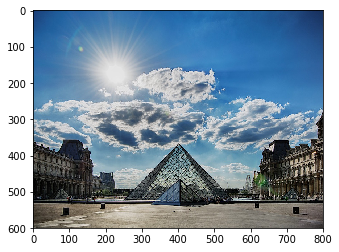

In [5]:
#Start with the Louvre picture as Content

content_image = imageio.imread("images/louvre.jpg")

plt.imshow(content_image)

3.1.1 - How do you ensure the generated image G matches the content of the image C?

As we saw in lecture, the earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes.

We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. In practice, you'll get the most visually pleasing results if you choose a layer in the middle of the network--neither too shallow nor too deep. (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

So, suppose you have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let$$a^{(G)}$$be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$
Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. (Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style const $J_{style}$.)

IT'S THE SAME UNRAVELLING THAT I USE FOR IMAGE CLASIFICATION WITH A REGULAR NEURAL NETWORK, LIKE THE CLASSICAL MNIST EXAMPLE. THEN I STACK ALL THE CHANNELS TO FORM A MATRIX.

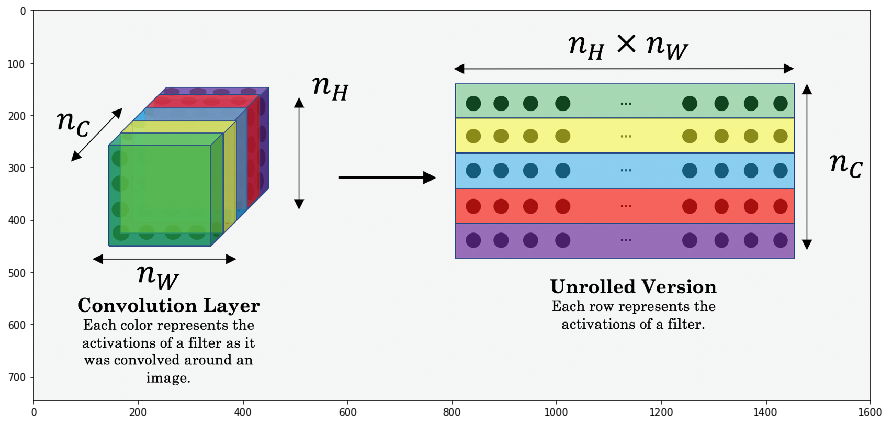

In [6]:

LOSS_image = imageio.imread("images/NST_LOSS.png")

plt.figure(figsize = (15,12))
plt.imshow(LOSS_image)

Now I compute the CONTENT cost. Then I'll do other things.

To do this:


*   Get dimensions of the hidden layer activations.
*   Unroll the activations tensor as in the picture above.
*   Compute the cost according to the equation above.




In [0]:
def compute_content_cost(a_C, a_G):
    """
    a_C is the tensor that contains the activations of the intermediate layer for the content image
    Dimension a_C = (1, H, W, c)
    a_G is the tensor that contains the activations of the intermediate layer for the generated image
    Dimension a_G = (1, H, W, c)
    
    Returns: J_content = scalar, result from the equation above.
    """
    
    #Get shape. Only once, it's the "same" tensor (variable) with different values for each case.
    
    m, n_H, n_W, n_c = a_G.get_shape().as_list()
    
    #Unraveling
    a_C_unravel = tf.reshape(a_C, [-1]) # Only -1 reshapes it to a vector and infers the length.
    a_G_unravel = tf.reshape(a_G, [-1])
    
    #Compute the cost.
    
    J_content = 1/(4 * n_H * n_W * n_c) * tf.reduce_sum((tf.square(a_C - a_G)))
    
    return J_content

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    a_G = tf.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    J_cont = compute_content_cost(a_C, a_G)
    print("J_content is: " + str(J_cont.eval()))

J_content is: 6.7655935


This seems to work. Now the style cost.

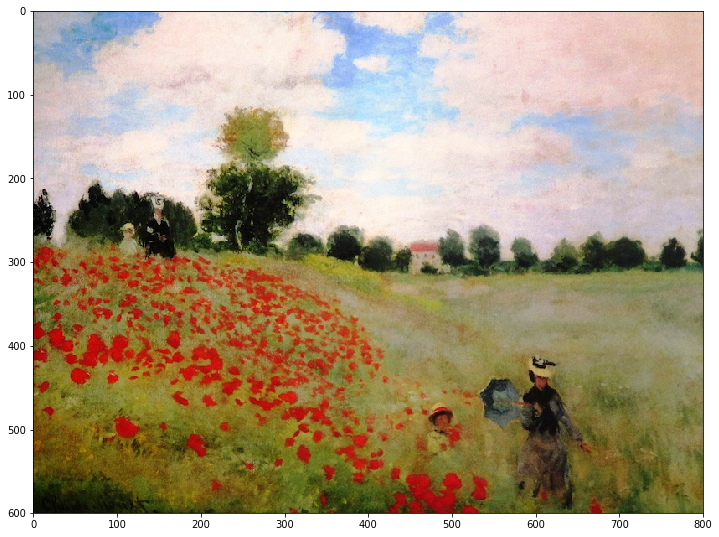

In [9]:
style_image = imageio.imread("images/monet_800600.jpg")
plt.figure(figsize = (12,10))
plt.imshow(style_image)

So as I know, the idea is to take the style and match it to the shapes of the content. Just to keep it in mind.

# Style matrix
The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large.

I remember studying something about this in uni, this is one of the few things I hadn't used yet. Who would have thought?

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context.

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:



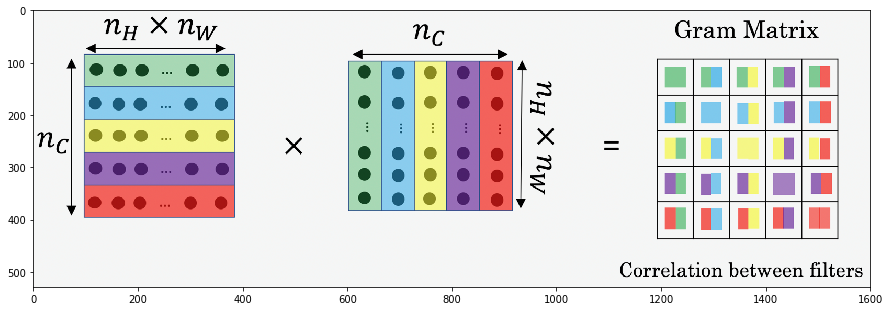

In [10]:

GRAM_image = imageio.imread("images/NST_GM.png")

plt.figure(figsize = (15,12))
plt.imshow(GRAM_image)

Keep in mind, the Gram matrix of a given matrix A is $G = A\cdot A^T$. And I only calculate this for the style.

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$.

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture.

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image.

In [0]:
def Gram_matrix(A):
    """
    A is input matrix, to calculate the Gram matrix from. Shape is (n_c, H*W)
    
    Output:
    
    GA is the Gram matrix of A. shape is (n_c, n_c)
    """
    #Not a difficult function to implement. But read the explanation above.
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean = 1, stddev = 4)
    GA = Gram_matrix(A)
    print("The Gram matrix is: GA = " + str(GA.eval()))

The Gram matrix is: GA = [[ 6.422305  -4.4291224 -2.096682 ]
 [-4.4291224 19.465837  19.563871 ]
 [-2.096682  19.563871  20.686462 ]]


## Now it's the style cost.

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$
where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.

In [0]:
def compute_layer_style_cost(a_S, a_G):
    """
    This computes the style cost for one layer. For several layers I just call this several times.
    The structure of this function is similar to the previous one. And the dimensions too, because it's the tensor with the activations of a given layer
    
    Input:
    a_S: tensor of dimension (1, H, W, n_c), for the style image activations
    a_G: tensor of dimension (1, H, W, n_c), for the generated image activations
    
    Return:
    J_style_layer =  cost of the single layer according to eq. 2 above. SCALAR
    
    """
    
    m, n_H, n_W, n_c = a_G.get_shape().as_list()
    
    #Now reshape the tensors to have them as a (H * W, n_c) matrix
    
    a_S = tf.reshape(a_S, [n_H * n_W, n_c])
    a_G = tf.reshape(a_G, [n_H * n_W, n_c])
    
    # Compute both Gram matrices
    
    GA_S = Gram_matrix(tf.transpose(a_S)) # Careful with the input dimensions, check above!
    GA_G = Gram_matrix(tf.transpose(a_G))
    
    # Now compute the cost
    
    J_style_layer = (1/(4 * (n_c * n_H * n_W)**2)) * tf.reduce_sum(tf.square(GA_S - GA_G))
    
    return J_style_layer
    

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    
    a_S = tf.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    a_G = tf.random_normal([1, 4, 4, 3], mean = 1, stddev = 4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("The style cost for this layer is: " + str(J_style_layer.eval()))

The style cost for this layer is: 9.190279


Now, to do things properly, I will need to call the function to compute the cost on several layers, not on one chosen at random. And I can add some weights. I will do it with a list.

In [0]:
STYLE_LAYERS = [("conv1_1", 0.2),
               ("conv2_1", 0.2),
               ("conv3_1", 0.2),
               ("conv4_1", 0.2),
               ("conv5_1", 0.2)]

Like this, I can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$
where the values for $\lambda^{[l]}$ are given in STYLE_LAYERS.

In [0]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    This function computes the cost for the style layers that I define. It's calling the previous function several times, which is actually doing the calculation.
    
    input: model = the (pretrained) model
    style layers = a list with the layers and the lambdas to use in the equation above.
    
    output: J_style, a scalar, which is the result of the equation above.
    
    """
    
    J_style = 0
    
    for layer_name, weight in STYLE_LAYERS:
        
        # TAke the corresponding layer
        out = model[layer_name]
        
        # a_S is the activations of the style run on this layer
        a_S = sess.run(out) # If I don't run it it's not evaluated.
        
        #a_G is the activations from the model on the current layer, which is NOT evaluated yet.
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        J_style = J_style + weight * J_style_layer # This the the equation above!
        
    return J_style

Now I combine the cost functions to create the meta cost function that they describe in the paper.

In [0]:
def total_cost(J_content, J_style, alpha = 1, beta = 1):
    """
    Simple linear combination of both cost functions.
    output is the total cost J, the inputs are the costs calculated by the functions above.
    """
    J = alpha * J_content + beta * J_style
    
    return J
    

In [83]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(13)
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 0.04137571660911499


Now start an interactive session to run and get evaluations automatically.

In [84]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


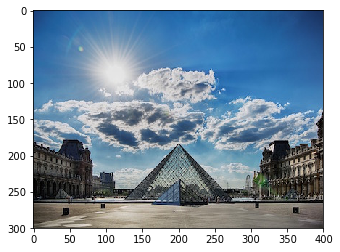

In [85]:
#Load and reshape the content image
content_image = imageio.imread("images/louvre_small.jpg")
plt.imshow(content_image) #The next function creates a tensor, which can't be plotted without selecting the relevant dimensions. Don't get into that now.
content_image = reshape_and_normalize_image(content_image)


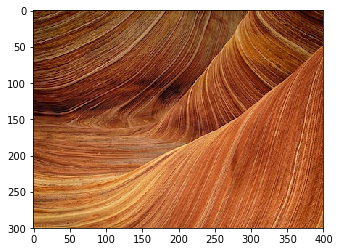

In [99]:
#Load and reshape the style image
style_image = imageio.imread("images/sandstone.jpg")
plt.imshow(style_image) #The next function creates a tensor, which can't be plotted without selecting the relevant dimensions. Don't get into that now.
style_image = reshape_and_normalize_image(style_image)


Now, I initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. Check the np_utils file, it's a simple combination of noise and the content image.

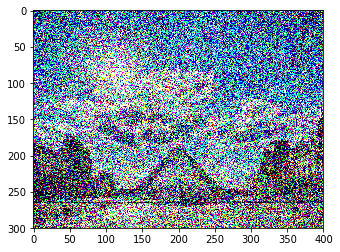

In [100]:
generated_image = generate_noise_image(content_image) #By adjusting the parameters in this function I can change the look of this starting point
plt.imshow(generated_image[0])

Now load the model.

In [0]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign a_C and a_G to be the appropriate hidden layer activations. We will use layer conv4_2 to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer.
4. Compute the content cost using a_C and a_G.

In [0]:
#Assign the content image to be the input to the VGG model.

sess.run(model["input"].assign(content_image))

# Select the output of conv4_2

out = model["conv4_2"]

# set a_C to be the tensor giving the activations of conv4_2

a_C = sess.run(out)

# Set a_G to be the same as out, which has not been evaluated yet. Later I will assign it to be the model input, as it should be.

a_G = out

#Compute cost

J_content = compute_content_cost(a_C, a_G) #And it's not evaluated yet!!!

In [0]:
# Now assign style to be the input

sess.run(model["input"].assign(style_image))

# Compute style cost

J_style = compute_style_cost(model, STYLE_LAYERS)

In [0]:
# Now calculate the combined loss function

J = total_cost(J_content, J_style)

Now define the optimizer and the function to optimize

In [0]:
optimizer = tf.train.AdamOptimizer(1) #these can also be inside the function or after

train_step = optimizer.minimize(J)

Now put all this steps together in a function, like normal people.

In [0]:
def model_network(sess, input_image, num_iterations):
    """
    I need to provide an image, a session to run and the num iters
    It returns the generated image    
    """
    
    # Initialize global variables. This is tf, not keras
    sess.run(tf.global_variables_initializer())
    
    # I pass the noisy input image through the network
    
    sess.run(model["input"].assign(input_image))
    
    # Start iterating
    
    total_cost = []
    content_cost = []
    style_cost = []
    
    for iter in range(num_iterations):
        
        sess.run(train_step)
        
        generated_image = sess.run(model["input"])
        
        # Print every 25 iterations
        
        if iter % 25 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(iter) + ":")
            print("Total cost = " + str(Jt))
            print("Content cost = " + str(Jc))
            print("Style cost = " + str(Js))
            total_cost.append(Jt)
            content_cost.append(Jc)
            style_cost.append(Js) # I could do it with a list only, I prefer to have them independently
            
            #save the image in the directory
#             print(generated_image.shape)
            imageio.imsave("output/" + str(iter) + ".jpg", generated_image[0, :, :, :])
    
    #Save the last image
    imageio.imsave("output/generated_image.jpg", generated_image[0, :, :, :])
    
    return generated_image, total_cost, content_cost, style_cost

In [0]:
!rm -rf output

%mkdir output

In [116]:
iterations = 1000
_, tot, cont, style = model_network(sess, generated_image, iterations)

Iteration 0:
Total cost = 395001820.0
Content cost = 14484.507
Style cost = 394987330.0


Iteration 25:
Total cost = 194874850.0
Content cost = 18101.994
Style cost = 194856750.0


Iteration 50:
Total cost = 104477096.0
Content cost = 22301.809
Style cost = 104454790.0


Iteration 75:
Total cost = 53384140.0
Content cost = 24418.701
Style cost = 53359720.0


Iteration 100:
Total cost = 27036244.0
Content cost = 25321.48
Style cost = 27010922.0


Iteration 125:
Total cost = 15004536.0
Content cost = 25543.564
Style cost = 14978992.0


Iteration 150:
Total cost = 9693786.0
Content cost = 25515.537
Style cost = 9668270.0


Iteration 175:
Total cost = 7070401.5
Content cost = 25510.371
Style cost = 7044891.0


Iteration 200:
Total cost = 5566136.0
Content cost = 25559.506
Style cost = 5540576.5


Iteration 225:
Total cost = 4580497.5
Content cost = 25616.238
Style cost = 4554881.5


Iteration 250:
Total cost = 3874041.2
Content cost = 25686.297
Style cost = 3848355.0


Iteration 275:
Total cost = 3340026.2
Content cost = 25768.941
Style cost = 3314257.2


Iteration 300:
Total cost = 2921327.8
Content cost = 25849.479
Style cost = 2895478.2


Iteration 325:
Total cost = 2584065.2
Content cost = 25919.309
Style cost = 2558146.0


Iteration 350:
Total cost = 2305104.0
Content cost = 25983.725
Style cost = 2279120.2


Iteration 375:
Total cost = 2072902.2
Content cost = 26035.273
Style cost = 2046867.0


Iteration 400:
Total cost = 1878319.5
Content cost = 26082.146
Style cost = 1852237.4


Iteration 425:
Total cost = 1711841.0
Content cost = 26127.389
Style cost = 1685713.6


Iteration 450:
Total cost = 1568388.8
Content cost = 26166.875
Style cost = 1542221.9


Iteration 475:
Total cost = 1443441.0
Content cost = 26203.309
Style cost = 1417237.8


Iteration 500:
Total cost = 1333482.5
Content cost = 26238.83
Style cost = 1307243.6


Iteration 525:
Total cost = 1236575.6
Content cost = 26272.012
Style cost = 1210303.6


Iteration 550:
Total cost = 1150809.8
Content cost = 26302.89
Style cost = 1124506.9


Iteration 575:
Total cost = 1074459.4
Content cost = 26328.914
Style cost = 1048130.5


Iteration 600:
Total cost = 1006598.06
Content cost = 26350.96
Style cost = 980247.1


Iteration 625:
Total cost = 945814.1
Content cost = 26370.426
Style cost = 919443.7


Iteration 650:
Total cost = 891306.25
Content cost = 26387.64
Style cost = 864918.6


Iteration 675:
Total cost = 842103.5
Content cost = 26404.438
Style cost = 815699.06


Iteration 700:
Total cost = 797453.0
Content cost = 26423.258
Style cost = 771029.75


Iteration 725:
Total cost = 756637.9
Content cost = 26442.906
Style cost = 730195.0


Iteration 750:
Total cost = 719446.6
Content cost = 26460.752
Style cost = 692985.9


Iteration 775:
Total cost = 685476.75
Content cost = 26476.512
Style cost = 659000.25


Iteration 800:
Total cost = 654401.06
Content cost = 26492.203
Style cost = 627908.9


Iteration 825:
Total cost = 626116.2
Content cost = 26506.77
Style cost = 599609.44


Iteration 850:
Total cost = 600147.56
Content cost = 26519.215
Style cost = 573628.4


Iteration 875:
Total cost = 576130.3
Content cost = 26531.59
Style cost = 549598.75


Iteration 900:
Total cost = 553968.2
Content cost = 26541.035
Style cost = 527427.1


Iteration 925:
Total cost = 533345.3
Content cost = 26549.479
Style cost = 506795.84


Iteration 950:
Total cost = 514100.75
Content cost = 26558.092
Style cost = 487542.66


Iteration 975:
Total cost = 496094.34
Content cost = 26565.285
Style cost = 469529.06


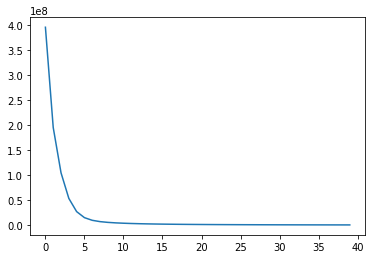

In [117]:
plt.plot(range(len(tot)), tot)

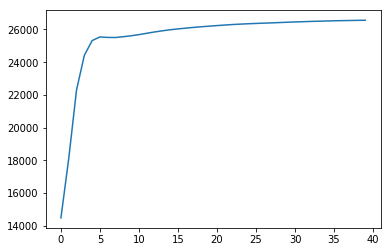

In [118]:
plt.plot(range(len(cont)), cont)

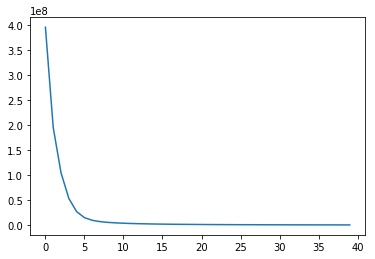

In [119]:
plt.plot(range(len(style)), style)